## This is an example of InfoGAN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
import util
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Main TFGAN library.
tfgan = tf.contrib.gan

ds = tf.contrib.distributions
layers = tf.contrib.layers
queues = tf.contrib.slim.queues
framework = tf.contrib.framework
slim = tf.contrib.slim


W1111 15:33:32.165236 220724 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()
    
def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        images_np = sess.run(tensor_to_visualize)
        
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')
    
def evaluate_tfgan_loss(gan_loss, sess, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with queues.QueueRunners(sess):
        gen_loss_np = sess.run(gan_loss.generator_loss)
        dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

def _graph_def_from_par_or_disk(filename):
  if filename is None:
    return tfgan.eval.get_graph_def_from_resource('./mnist/data/classify_mnist_graph_def.pb')
  else:
    return tfgan.eval.get_graph_def_from_disk(filename)
        
def mnist_score(images, graph_def_filename=None, input_tensor='inputs:0',
                output_tensor='logits:0', num_batches=1):
  """Get MNIST logits of a fully-trained classifier.
  Args:
    images: A minibatch tensor of MNIST digits. Shape must be
      [batch, 28, 28, 1].
    graph_def_filename: Location of a frozen GraphDef binary file on disk. If
      `None`, uses a default graph.
    input_tensor: GraphDef's input tensor name.
    output_tensor: GraphDef's output tensor name.
    num_batches: Number of batches to split `generated_images` in to in order to
      efficiently run them through Inception.
  Returns:
    A logits tensor of [batch, 10].
  """
  images.shape.assert_is_compatible_with([None, 28, 28, 1])

  graph_def = _graph_def_from_par_or_disk(graph_def_filename)
  mnist_classifier_fn = lambda x: tfgan.eval.run_image_classifier(  # pylint: disable=g-long-lambda
      x, graph_def, input_tensor, output_tensor)

  score = tfgan.eval.classifier_score(
      images, mnist_classifier_fn, num_batches)
  score.shape.assert_is_compatible_with([])

  return score


In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print(mnist)
datasets = mnist.train.images
datasets = datasets.reshape((55000, 28,28, 1))
datasets = tf.data.Dataset.from_tensor_slices(datasets[:54976]).shuffle(54976).batch(32)
iterator = tf.compat.v1.data.make_initializable_iterator(datasets)
#iterator = datasets.make_one_shot_iterator()
real_images = iterator.get_next()

W1111 15:33:32.207095 220724 deprecation.py:323] From <ipython-input-3-6e4fe15de5a8>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1111 15:33:32.211084 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1111 15:33:32.215075 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and

Extracting MNIST_data/train-images-idx3-ubyte.gz


W1111 15:33:32.619797 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1111 15:33:32.631766 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W1111 15:33:32.740301 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002213C7F5748>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002213C7F58D0>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x000002213C7F59B0>)


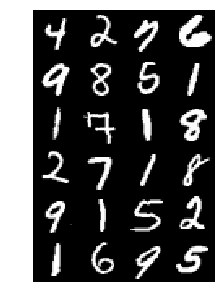

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer)
    img_np = sess.run(real_images)
    
    img_np = np.array(img_np)    
    image_rows = [np.concatenate(img_np[i:i+6], axis=0) for i in range(0, 32, 8)]
    tiled_images = np.concatenate(image_rows, axis=1)
    
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(np.squeeze(tiled_images), cmap='gray')

## define the generator function

In [5]:
def infogan_generator(inputs, categorical_dim, weight_decay=2.5e-5,
                      is_training=True):
    """InfoGAN discriminator network on MNIST digits.
    
    Based on a paper https://arxiv.org/abs/1606.03657 and their code
    https://github.com/openai/InfoGAN.
    
    Args:
        inputs: A 3-tuple of Tensors (unstructured_noise, categorical structured
            noise, continuous structured noise). `inputs[0]` and `inputs[2]` must be
            2D, and `inputs[1]` must be 1D. All must have the same first dimension.
        categorical_dim: Dimensions of the incompressible categorical noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    unstructured_noise, cat_noise, cont_noise = inputs
    cat_noise_onehot = tf.one_hot(cat_noise, categorical_dim)
    all_noise = tf.concat([unstructured_noise, cat_noise_onehot, cont_noise], axis=1)
    
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training):
        net = layers.fully_connected(all_noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 128)
        net = tf.reshape(net, [-1, 7, 7, 128])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)
    
        return net

In [6]:
def infogan_discriminator(img, unused_conditioning, weight_decay=2.5e-5,
                          categorical_dim=10, continuous_dim=2, is_training=True):
    """InfoGAN discriminator network on MNIST digits.
    
    Based on a paper https://arxiv.org/abs/1606.03657 and their code
    https://github.com/openai/InfoGAN.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        categorical_dim: Dimensions of the incompressible categorical noise.
        continuous_dim: Dimensions of the incompressible continuous noise.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real, and a list of posterior
        distributions for each of the noise vectors.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        net = layers.fully_connected(net, 1024, normalizer_fn=layers.layer_norm)
    
        logits_real = layers.fully_connected(net, 1, activation_fn=None)

        # Recognition network for latent variables has an additional layer
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            encoder = layers.fully_connected(
                net, 128, normalizer_fn=layers.batch_norm)

        # Compute logits for each category of categorical latent.
        logits_cat = layers.fully_connected(
            encoder, categorical_dim, activation_fn=None)
        q_cat = ds.Categorical(logits_cat)

        # Compute mean for Gaussian posterior of continuous latents.
        mu_cont = layers.fully_connected(
            encoder, continuous_dim, activation_fn=None)
        sigma_cont = tf.ones_like(mu_cont)
        q_cont = ds.Normal(loc=mu_cont, scale=sigma_cont)

        return logits_real, [q_cat, q_cont]

## Extra infomation of InfoGAN

In [7]:
def get_infogan_noise(batch_size, categorical_dim, structured_continuous_dim,
                      total_continuous_noise_dims):
  """Get unstructured and structured noise for InfoGAN.
  Args:
    batch_size: The number of noise vectors to generate.
    categorical_dim: The number of categories in the categorical noise.
    structured_continuous_dim: The number of dimensions of the uniform
      continuous noise.
    total_continuous_noise_dims: The number of continuous noise dimensions. This
      number includes the structured and unstructured noise.
  Returns:
    A 2-tuple of structured and unstructured noise. First element is the
    unstructured noise, and the second is a 2-tuple of
    (categorical structured noise, continuous structured noise).
  """
  # Get unstructurd noise.
  unstructured_noise = tf.random_normal(
      [batch_size, total_continuous_noise_dims - structured_continuous_dim])

  # Get categorical noise Tensor.
  categorical_dist = ds.Categorical(logits=tf.zeros([categorical_dim]))
  categorical_noise = categorical_dist.sample([batch_size])

  # Get continuous noise Tensor.
  continuous_dist = ds.Uniform(-tf.ones([structured_continuous_dim]),
                               tf.ones([structured_continuous_dim]))
  continuous_noise = continuous_dist.sample([batch_size])

  return [unstructured_noise], [categorical_noise, continuous_noise]

In [8]:
# Dimensions of the structured and unstructured noise dimensions.
cat_dim, cont_dim, noise_dims = 10, 2, 64
batch_size =32

generator_fn = functools.partial(infogan_generator, categorical_dim=cat_dim)
discriminator_fn = functools.partial(
    infogan_discriminator, categorical_dim=cat_dim,
    continuous_dim=cont_dim)
unstructured_inputs, structured_inputs = get_infogan_noise(
    batch_size, cat_dim, cont_dim, noise_dims)

infogan_model = tfgan.infogan_model(
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    real_data=real_images,
    unstructured_generator_inputs=unstructured_inputs,
    structured_generator_inputs=structured_inputs)

W1111 15:33:49.893572 220724 deprecation.py:323] From <ipython-input-7-43c24f9edcb0>:21: Categorical.__init__ (from tensorflow.python.ops.distributions.categorical) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W1111 15:33:49.902548 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\python\ops\distributions\categorical.py:242: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributi

## Define the loss function

In [9]:
infogan_loss = tfgan.gan_loss(
    infogan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss,
    gradient_penalty_weight=1.0,
    mutual_information_penalty_weight=1.0)

# Sanity check that we can evaluate our losses.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(iterator.initializer)
    evaluate_tfgan_loss(infogan_loss, sess)
    

W1111 15:33:51.858907 220724 deprecation.py:323] From C:\Users\jw855-admin\AppData\Local\conda\conda\envs\huawei\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Generator loss: 1.437831
Discriminator loss: 4.431798


# Training and Evaluation
defining the optimizer

In [10]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.00009, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    infogan_model,
    infogan_loss,
    generator_optimizer,
    discriminator_optimizer)

W1111 15:34:05.003285 220724 training.py:423] update_ops in create_train_op does not contain all the update_ops in GraphKeys.UPDATE_OPS
W1111 15:34:05.486083 220724 training.py:423] update_ops in create_train_op does not contain all the update_ops in GraphKeys.UPDATE_OPS


# Evaluation the MNIST dataset
Generate some images to evaluate MNIST score.

In [16]:
# Set up images to evaluate MNIST score.
images_to_eval = 500
assert images_to_eval % cat_dim == 0

unstructured_inputs = tf.random_normal([images_to_eval, noise_dims-cont_dim])
cat_noise = tf.constant(list(range(cat_dim)) * (images_to_eval // cat_dim))
cont_noise = tf.random_uniform([images_to_eval, cont_dim], -1.0, 1.0)

with tf.variable_scope(infogan_model.generator_scope, reuse=True):
    eval_images = infogan_model.generator_fn(
        (unstructured_inputs, cat_noise, cont_noise))

MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'
eval_score = mnist_score(
    eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Generate three sets of images to visualize the effect of each of the structured noise
# variables on the output.
rows = 2
categorical_sample_points = np.arange(0, 10)
continuous_sample_points = np.linspace(-1.0, 1.0, 10)
noise_args = (rows, categorical_sample_points, continuous_sample_points,
              noise_dims-cont_dim, cont_dim)

display_noises = []
display_noises.append(util.get_eval_noise_categorical(*noise_args))
display_noises.append(util.get_eval_noise_continuous_dim1(*noise_args))
display_noises.append(util.get_eval_noise_continuous_dim2(*noise_args))

display_images = []
for noise in display_noises:
    with tf.variable_scope('Generator', reuse=True):
        print("component1", noise[0].shape)
        print("component2",noise[1].shape)
        print("component3",noise[2].shape)
        display_images.append(infogan_model.generator_fn(noise, is_training=False))

display_img = tfgan.eval.image_reshaper(
    tf.concat(display_images, 0), num_cols=10)

component1 (20, 62)
component2 (20,)
component3 (20, 2)
component1 (20, 62)
component2 (20,)
component3 (20, 2)
component1 (20, 62)
component2 (20,)
component3 (20, 2)


Training step: 0
Time since start: 0.741507 m
Steps per min: 0.000000


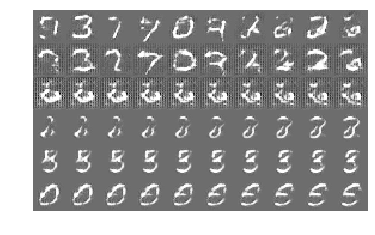

Current loss: 1.537903
Current MNIST score: 4.519995
Training step: 30
Time since start: 17.838906 m
Steps per min: 1.681717


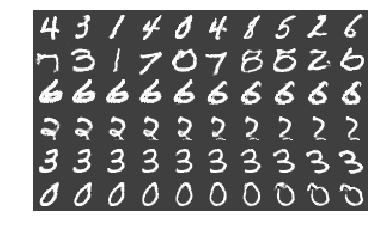

Current loss: 1.564476
Current MNIST score: 7.615233
Training step: 60
Time since start: 35.071429 m
Steps per min: 1.710794


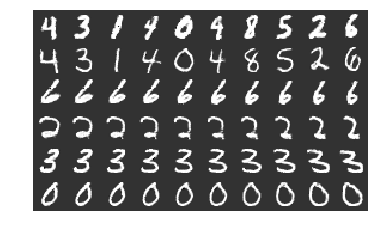

Current loss: 1.522903
Current MNIST score: 7.651188
Training step: 90
Time since start: 52.285658 m
Steps per min: 1.721313


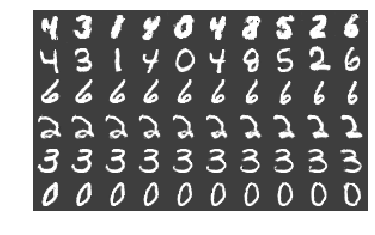

Current loss: 1.575639
Current MNIST score: 7.731919
Training step: 120
Time since start: 69.473870 m
Steps per min: 1.727268


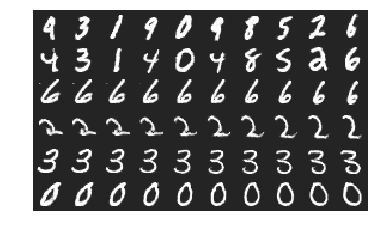

Current loss: 1.532305
Current MNIST score: 7.604968


In [13]:
global_step = tf.train.get_or_create_global_step()
train_step_fn = tfgan.get_sequential_train_steps()
loss_values, mnist_score_values  = [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    sess.run(iterator.initializer)
    for i in xrange(150):
        while True:
            try:
                cur_loss, _ = train_step_fn(
                    sess, gan_train_ops, global_step, train_step_kwargs={})
                loss_values.append((i, cur_loss))
            except tf.errors.OutOfRangeError:
                sess.run(iterator.initializer)
                break
        
        if i % 30 == 0:
            mnist_score_np, display_img_np = sess.run([eval_score, display_img])
            mnist_score_values.append((i, mnist_score_np))
            visualize_training_generator(i, start_time, display_img_np)
            print('Current loss: %f' % cur_loss)
            print('Current MNIST score: %f' % mnist_score_values[-1][1])